In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.util.systems import Linear2D
import pandas as pd
import warnings
import scipy
warnings.filterwarnings("ignore")

/Users/sbittner/anaconda/envs/dsn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


ModuleNotFoundError: No module named 'seaborn'

In [12]:
# set fixed params

# set behavior
tau = 1.0
fixed_params = {'tau':tau}
omega = 1
mu = np.array([0.0, 2*np.pi*omega]);
Sigma = np.array([0.1, 0.1]);
behavior = {'type':'oscillation', 'means':mu, 'variances':Sigma};

# instantiate linear 2D system
system = Linear2D(fixed_params, behavior);


In [21]:
# create test parameter grid
start = -10.0;
stop = 10.0;
res = 2.0;
eps = .001;
vals = np.arange(start, stop+eps, res);
num_pts = vals.shape[0];

total_pts = num_pts**4;
params = np.zeros((total_pts,4));
T_a_valid = np.zeros((total_pts, 6));
ind = 0;
for i in range(num_pts):
    a1 = vals[i];
    for j in range(num_pts):
        a2 = vals[j];
        for k in range(num_pts):
            a3 = -vals[k];
            for l in range(num_pts):
                a4 = vals[l];
                params[ind,:] = np.array([a1, a2, a3, a4]);
                ind += 1;

num_params = system.D;
K = 1;
M = total_pts;
phi = tf.placeholder(dtype=tf.float64, shape=(K, M, num_params));

T_a = system.compute_suff_stats(phi);

_phi = np.expand_dims(params, 0);

with tf.Session() as sess:
    _T_a = sess.run(T_a, {phi:_phi});
mu = system.compute_mu()


T_x_inds = range(system.num_suff_stats)    
nsamps = _phi.shape[1];
distance = np.zeros((nsamps,));
for i in range(nsamps):
    distance[i] = np.linalg.norm(_T_a[0,i,T_x_inds] - mu[T_x_inds]);
print(distance.shape)

(14641,)


[False False False ... False False False]


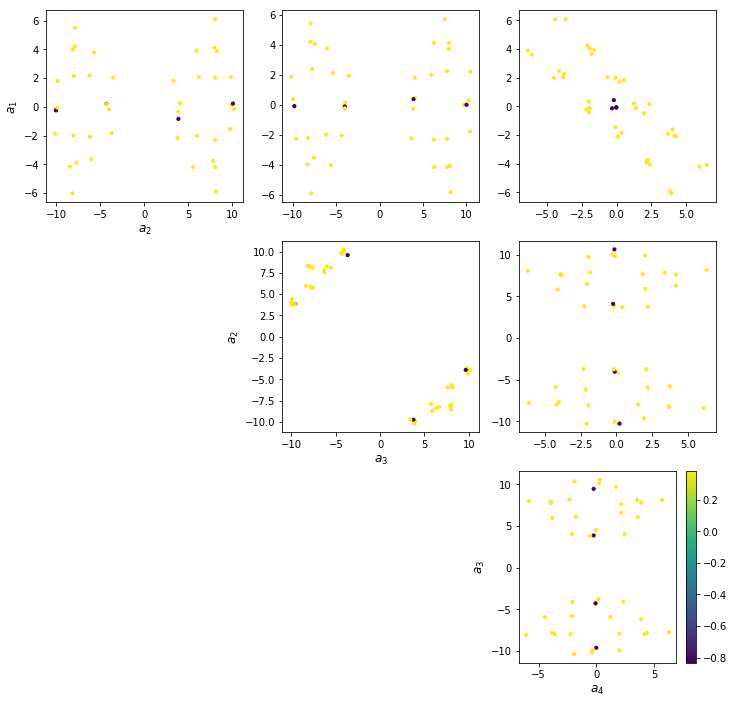

In [23]:
plot_type = 'thresh'
if (plot_type == 'all'):
    nsamps = _phi.shape[1];
    inds = np.random.permutation(nsamps);
elif (plot_type == 'thresh'):
    thresh = 1.0
    inds = np.log(distance) < thresh
    print(inds)
    nsamps = int(np.sum(inds))
    

jitter_std = res/8.0
figsize = (12,12);
fontsize = 12;
fig, axs = plt.subplots(system.D-1, system.D-1, figsize=figsize);
for i in range(system.D-1):
    for j in range(1, system.D):
        ax = axs[i][j-1]
        if (j > i):
            jitter_x = np.random.normal(0,jitter_std,(nsamps,));
            jitter_y = np.random.normal(0,jitter_std,(nsamps,));
            h = ax.scatter(_phi[0,inds,j]+jitter_x, _phi[0,inds,i]+jitter_y, s=10, c=np.log(distance[inds]))
        else:
            ax.axis('off')
            
        if (j==i+1):
            ax.set_xlabel(system.z_labels[j], fontsize=fontsize)
            ax.set_ylabel(system.z_labels[i], fontsize=fontsize)

plt.colorbar(h)    
plt.show();

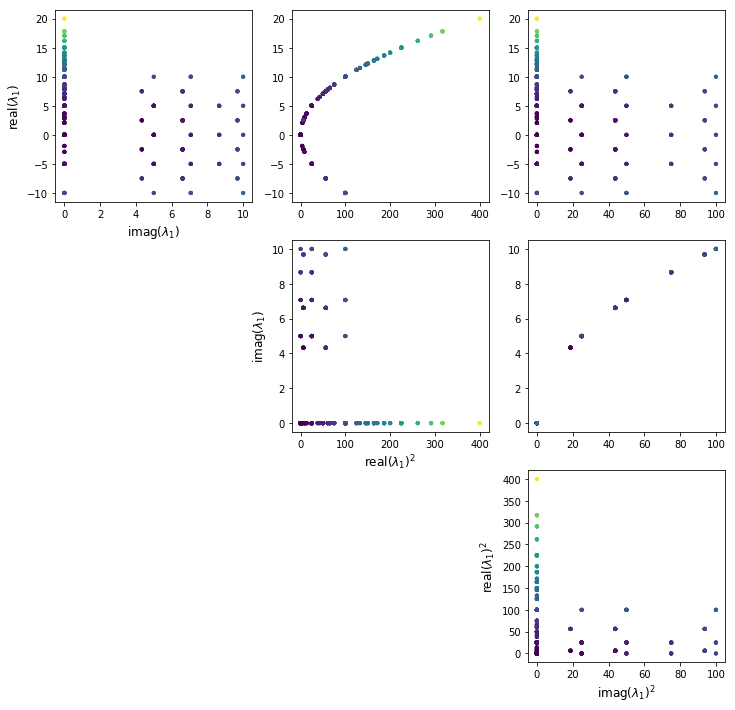

In [11]:
figsize = (12,12);
fontsize = 12;
fig, axs = plt.subplots(system.D-1, system.D-1, figsize=figsize);
for i in range(system.D-1):
    for j in range(1, system.D):
        ax = axs[i][j-1]
        if (j > i):
            ax.scatter(_T_a[0,inds,j], _T_a[0,inds,i], s=10, c=distance[inds]);
        else:
            ax.axis('off')
            
        if (j==i+1):
            ax.set_xlabel(system.T_x_labels[j], fontsize=fontsize)
            ax.set_ylabel(system.T_x_labels[i], fontsize=fontsize)
    

plt.show();

In [22]:
print(mu)

[  0.          12.56637061   1.         158.91367042]
